In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Inspect data
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
# Get header names from Measurement data
columns = inspector.get_columns("measurement")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Get header names from Station data
columns = inspector.get_columns("station")
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Design a query to retrieve the last 12 months of precipitation data
# The last date in the data is 2017-08-23
precip = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date > "2016-08-22").all()

In [15]:
# Save the query results as a Pandas DataFrame and 
df_precip = pd.DataFrame(precip)
df_precip.columns = precip[0].keys()

# Set the index to date and sort by date
df_precip = df_precip.set_index("date").sort_index()
df_precip = df_precip.dropna()
df_precip.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


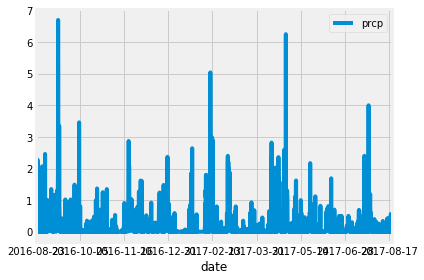

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
bar_precip = df_precip.plot()
plt.tight_layout()
plt.savefig("precip_MOSHER.png")

In [19]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_precip = df_precip.describe()
summary_precip

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


## Station Analysis

In [20]:
# Design a query to calculate the total number of stations.
total_stations = session.query(Measurement.station).group_by(Measurement.station).count()
total_stations

9

In [21]:
# Design a query to find the most active stations.
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.station).label("count")).\
group_by(Measurement.station).order_by(desc("count")).all()
station_activity
# The stations that was the most active was 'USC00519281'

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
temps_most_active_station = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), 
                                          func.avg(Measurement.tobs)).filter(Measurement.station == "USC00519281").\
                                            all()
temps_most_active_station

[(54.0, 85.0, 71.66378066378067)]

## Temperature Analysis

In [23]:
# Design a query to retrieve the last 12 months of temperature observation data (tobs).
# Filter by the station with the highest number of observations.
temp = session.query(Measurement.date, Measurement.tobs).filter(Measurement.station == "USC00519281", 
                                                                Measurement.date > "2016-08-22").all()
df_temp = pd.DataFrame(temp)
df_temp.columns = temp[0].keys()
df_temp

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


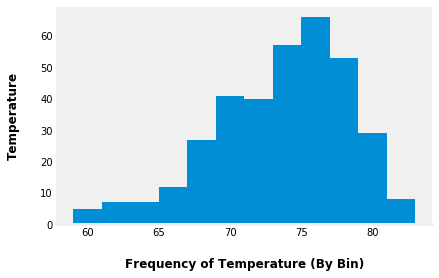

In [25]:
# Plot the results as a histogram with `bins=12`.
ax = df_temp.hist(column='tobs', bins=12, grid=False)

ax = ax[0]
for x in ax:

    # Despine
    x.spines['right'].set_visible(False)
    x.spines['top'].set_visible(False)
    x.spines['left'].set_visible(False)

    # Switch off ticks
    x.tick_params(axis="both", which="both", bottom="off", top="off", 
                  labelbottom="on", left="off", right="off", labelleft="on")

    # Remove title
    x.set_title("")

    # Set x-axis label
    x.set_xlabel("Frequency of Temperature (By Bin)", labelpad=20, weight='bold', size=12)

    # Set y-axis label
    x.set_ylabel("Temperature", labelpad=20, weight='bold', size=12)
    
plt.savefig("temp_MOSHER.png")